## The New York Times Covid-19 Database

The New York Times Covid-19 Database is 
a county-level database of confirmed cases and deaths, 
compiled from state and local governments and health departments across the United States.
The initial release of the database was on Thursday, March 26, 2020, and it is updated daily. 

These data have fueled many articles and graphics by The Times; these are updated regularly at
[https://www.nytimes.com/interactive/2020/us/coronavirus-us-cases.html](https://www.nytimes.com/interactive/2020/us/coronavirus-us-cases.html). 
The Times has created many visualizations that are effective communications of important information about the pandemic. 

The data are publically available via GitHub: [https://github.com/nytimes/covid-19-data](https://www.nytimes.com/interactive/2020/us/coronavirus-us-cases.html).  In this illustration we will only use
the data aggregated at the state level. 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import dateutil
import numpy as np
import statsmodels.api as sm
%matplotlib inline

covid_df = pd.read_csv("https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv", dtype={"fips": str})


### Process the recent data

Here is a function that creates a dataframe with the recent Covid-19 statistics for a given state. Just pass in the name of the state as a string.


In [2]:
def process_recent_data(state, days_back=40):
    # the time stamps in the original table are just strings, we convert them to have type date
    date = [dateutil.parser.parse(d) for d in np.array(covid_df['date'])]
    last_date = max(date)

    days = np.array([(last_date - d).days for d in date])
    df_recent = covid_df[days < days_back]
    df_recent = df_recent.reset_index().drop('index', 1)

    cases = np.array(df_recent['cases'])
    state_df = df_recent[df_recent['state']==state]
    state_df = state_df.reset_index().drop('index', 1)

    return state_df


### Fit a linear and quadratic regression model

Now we'll fit a linear model to the data. To do this we'll use the <code>statsmodels.api.OLS</code> function for "ordinary least squares."  First, to find the number of <i>new</i> cases each day, we'll compute the difference between the cases on a given day and the cases on the previous day. This is conveniently done with the function <code>numpy.diff</code>. Then we'll fit a quadratic regression model.


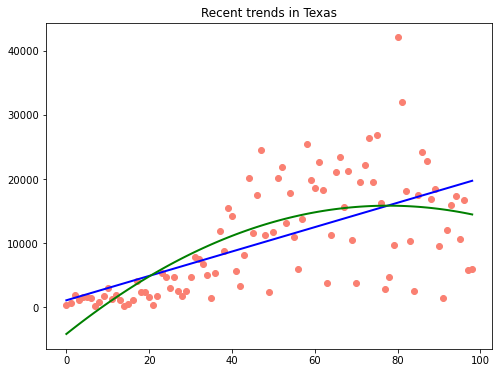

In [5]:

state_name = 'Texas'
df = process_recent_data(state=state_name, days_back=100)

new_cases = list(np.diff(np.array(df['cases'])))
x = np.arange(len(new_cases))

plt.figure(figsize=(8,6))

X1 = pd.DataFrame()
X1['x'] = x
X1 = sm.add_constant(X1) # to get the intercept term
model = sm.OLS(new_cases, X1).fit()

X2 = pd.DataFrame()
X2['x'] = x
X2['x2'] = x*x
#X2['x3'] = x*x*x
#X2['x4'] = x*x*x*x
#X2['x5'] = x*x*x*x*x
#X2['x6'] = x*x*x*x*x*x

X2 = sm.add_constant(X2)
model2 = sm.OLS(new_cases,X2).fit()

plt.plot(x, model.predict(X1), linewidth=2, color='blue')
plt.plot(x, model2.predict(X2), linewidth=2, color='green')
plt.scatter(x, new_cases, color='salmon')
_ = plt.title('Recent trends in %s' % state_name)

## Think about the results...

Which model has higher bias?  Higher variance? Which model is more complex? Try adding higher powers of <code>x</code>. How do the results change?